In [26]:
# extract_info_from_pcap 函數

from scapy.all import *
import pandas as pd

def extract_info_from_pcap(file_path):
    """
    從 pcap 檔案中提取資訊，計算連接次數，並合併重複的行。
    
    此函數將讀取 pcap 檔案，從中提取每個封包的來源 IP、目的地 IP 和目的地端口資訊。
    接著，根據這些屬性計算每個唯一組合的出現次數，同時合併重複的行。
    最後，將這些資料以及連接次數存儲至一個 DataFrame 中。

    :param file_path: pcap 檔案的路徑
    :return: 包含來源 IP、目的地 IP、目的地端口和連接次數的 DataFrame
    """    
    packets = rdpcap(file_path)
    records = []

    for packet in packets:
        if IP in packet and TCP in packet:
            source = packet[IP].src
            target = packet[IP].dst
            port = packet[TCP].dport
            records.append([source, target, port])

    df = pd.DataFrame(records, columns=['source', 'target', 'port'])
    df = df.groupby(['source', 'target', 'port']).size().reset_index(name='conncount')

    return df


In [27]:
# extract_info_from_json 函數

import json
import pandas as pd

def extract_info_from_json(file_path):
    """
    從包含多行 JSON 數據的檔案中提取特定資訊，計算警告次數，並合併重複的行。

    此函數將逐行讀取指定的 JSON 檔案，對於包含 'alert' 鍵的行，提取源 IP 地址、目標 IP 地址、目標端口、警告嚴重性、簽名 ID 和簽名。
    之後，根據源 IP 地址、目標 IP 地址、簽名 ID 和簽名的唯一組合計算每組的出現次數，同時合併具有相同這些屬性的行。
    最後，這些資料將存儲至一個 DataFrame 中，僅包含所需的欄位：來源 IP、目標 IP、警告次數、嚴重性和簽名。

    :param file_path: JSON 檔案的路徑
    :return: 包含來源 IP、目標 IP、警告次數、嚴重性和簽名的 DataFrame
    """
    records = []

    with open(file_path, 'r') as file:
        for line in file:
            try:
                entry = json.loads(line)
                if 'alert' in entry:
                    record = {
                        'source': entry['src_ip'],
                        'target': entry['dest_ip'],
                        'port': entry['dest_port'],
                        'severity': entry['alert']['severity'],
                        'signature_id': entry['alert']['signature_id'],
                        'signature': entry['alert'].get('signature', '')  # 使用 get 方法以處理缺少 'signature' 鍵的情況
                    }
                    records.append(record)
            except json.JSONDecodeError:
                continue

    df = pd.DataFrame(records)
    df = df.groupby(['source', 'target', 'signature_id', 'signature']).agg({'severity': 'first', 'signature_id': 'size'}).rename(columns={'signature_id': 'alertcount'}).reset_index()
    df = df[['source', 'target', 'alertcount', 'severity', 'signature']]

    return df



In [123]:
# 數據處理模組

import pandas as pd

def process_data(df_pcap, df_event):
    # 合併從 pcap 和 JSON 檔案提取的 DataFrame
    df_combined = pd.concat([df_pcap, df_event], ignore_index=True)

    # 檢查並處理可能的數據缺失問題
    df_combined.fillna(0, inplace=True)
    
    # 轉換數據類型，確保後續計算可以正確進行
    df_combined['conncount'] = df_combined['conncount'].astype('int64')
    df_combined['alertcount'] = df_combined['alertcount'].astype('int64')
    df_combined['severity'] = df_combined['severity'].astype('int64', errors='ignore')
    df_combined['port'] = df_combined['port'].astype('int64', errors='ignore')
    
    # 計算權重
    # 注意：如果 'alertcount' 或 'conncount' 的最大值為0，應避免除以0的錯誤
    max_alertcount = df_combined['alertcount'].max()
    max_conncount = df_combined['conncount'].max()
    
    if max_alertcount > 0:
        df_combined['alertweight'] = df_combined['alertcount'] / max_alertcount * 10 + 0.1
    else:
        df_combined['alertweight'] = 0.1

    if max_conncount > 0:
        df_combined['connweight'] = df_combined['conncount'] / max_conncount * 10 + 0.1
    else:
        df_combined['connweight'] = 0.1
    
    return df_combined


In [124]:
# 設定檔案路徑
file_path_pcap = r'C:\Users\onion\OneDrive\Desktop\安聖\威脅練補團隊\Code Testing\pcap_graph\data\20240124.pcapng'

# 執行數據提取
print("開始提取 PCAP 數據...")
df_pcap = extract_info_from_pcap(file_path_pcap)
print(f"PCAP 數據提取完成，共提取到 {len(df_pcap)} 條記錄。")

df_pcap.head(3)

開始提取 PCAP 數據...
PCAP 數據提取完成，共提取到 4382 條記錄。


,source,target,port,conncount
0,108.177.125.119,192.168.0.26,56563,8
1,108.177.125.136,192.168.0.26,56561,9
2,108.177.125.95,192.168.0.26,56566,9


In [125]:
# 設定檔案路徑
file_path_json = r'C:\Users\onion\OneDrive\Desktop\安聖\威脅練補團隊\Code Testing\pcap_graph\data\eve_20240315.json'

print("開始提取 JSON 數據...")
df_event = extract_info_from_json(file_path_json)
print(f"JSON 數據提取完成，共提取到 {len(df_event)} 條記錄。")

df_event.head(15)

開始提取 JSON 數據...
JSON 數據提取完成，共提取到 22 條記錄。


,source,target,alertcount,severity,signature
0,192.168.0.1,192.168.0.242,25,3,Detect lateral movement by flow analysis level 3
1,192.168.0.1,192.168.0.242,5,3,Detect lateral movement by flow analysis level 2
2,192.168.0.1,192.168.0.26,34,3,Detect lateral movement by flow analysis level 3
3,192.168.0.1,192.168.0.26,4,3,Detect lateral movement by flow analysis level 2
4,192.168.0.1,192.168.0.26,1,3,Detect lateral movement by flow analysis level 1
5,192.168.0.10,192.168.0.116,105,3,Detect lateral movement by flow analysis level 3
6,192.168.0.10,192.168.0.116,11,3,Detect lateral movement by flow analysis level 2
7,192.168.0.10,192.168.0.116,4,3,Detect lateral movement by flow analysis level 1
8,192.168.0.10,192.168.0.129,4596,3,Detect lateral movement by flow analysis level 3
9,192.168.0.10,192.168.0.129,768,3,Detect lateral movement by flow analysis level 2


In [126]:
df_event.head(15)

,source,target,alertcount,severity,signature
0,192.168.0.1,192.168.0.242,25,3,Detect lateral movement by flow analysis level 3
1,192.168.0.1,192.168.0.242,5,3,Detect lateral movement by flow analysis level 2
2,192.168.0.1,192.168.0.26,34,3,Detect lateral movement by flow analysis level 3
3,192.168.0.1,192.168.0.26,4,3,Detect lateral movement by flow analysis level 2
4,192.168.0.1,192.168.0.26,1,3,Detect lateral movement by flow analysis level 1
5,192.168.0.10,192.168.0.116,105,3,Detect lateral movement by flow analysis level 3
6,192.168.0.10,192.168.0.116,11,3,Detect lateral movement by flow analysis level 2
7,192.168.0.10,192.168.0.116,4,3,Detect lateral movement by flow analysis level 1
8,192.168.0.10,192.168.0.129,4596,3,Detect lateral movement by flow analysis level 3
9,192.168.0.10,192.168.0.129,768,3,Detect lateral movement by flow analysis level 2


In [127]:
dfc = process_data(df_pcap, df_event)
print(dfc.head(5))
print(dfc.tail(5))

            source        target   port  conncount  alertcount  severity  \
0  108.177.125.119  192.168.0.26  56563          8           0         0   
1  108.177.125.136  192.168.0.26  56561          9           0         0   
2   108.177.125.95  192.168.0.26  56566          9           0         0   
3   108.177.97.132  192.168.0.26  56555          9           0         0   
4   108.177.97.132  192.168.0.26  56556         10           0         0   

  signature  alertweight  connweight  
0         0          0.1    0.103043  
1         0          0.1    0.103423  
2         0          0.1    0.103423  
3         0          0.1    0.103423  
4         0          0.1    0.103803  
             source          target  port  conncount  alertcount  severity  \
4399  192.168.0.242    91.189.91.82     0          0           2         3   
4400   192.168.0.26    192.168.0.13     0          0           1         3   
4401   192.168.0.26   23.45.197.184     0          0           3         3 

In [128]:
# Import libraries and dependencies

import networkx as nx
import matplotlib.pyplot as plt
import ipaddress
import math
from collections import Counter
import networkx.algorithms.community as nxcom

In [129]:
# Create graphs
# Create our graph from our pandas dataframe
G = nx.from_pandas_edgelist(dfc, source="source", target="target", edge_key="port", edge_attr=True, create_using=nx.MultiDiGraph())
G2 = nx.from_pandas_edgelist(dfc, source="source", target="target", edge_attr=True, create_using=nx.Graph())

# add our node attributes
# List of desired source attributes:
src_attributes = [ "alertcount","severity", "alertweight", "connweight"]

# Iterate over df rows and set source node attributes:
for index, row in dfc.iterrows():
    src_attr_dict = {k: row.to_dict()[k] for k in src_attributes}    
    G.nodes[row["source"]].update(src_attr_dict)
    G.nodes[row["target"]].update(src_attr_dict)

In [130]:
# Check how many nodes the graph contains to set attributes for figure size
n = len(G.nodes)
print("n = ",n)
if n > 1000:
    largegraph = True
    fig_size = (50, 40)
    print("Large Graph: %s , using large graph functions" % n)
elif 500 < n <= 1000:
    fig_size = (40, 30)
    largegraph = False
    print("Small Graph: %s, figsize: %s" % (n, fig_size))
elif 250 < n <= 500:
    fig_size = (30, 20)
    largegraph = False
    print("Small Graph: %s, figsize: %s" % (n, fig_size))
elif 0 < n <= 250:
    fig_size = (18, 15)
    largegraph = False
    print("Small Graph: %s, figsize: %s" % (n, fig_size))

n =  89
Small Graph: 89, figsize: (18, 15)


In [131]:
print("Graph analysis\n")
print("Multi-edge directed Graph\n")
print("Number of nodes: %s\t" % len(G.nodes))
print("Number of edges: %s\n" % len(G.edges))
print("Graph density: %s\n" % nx.density(G))
print("Graph is directed: %s\n" % G.is_directed())
print("Graph is weighted: %s\n" % nx.is_weighted(G))
print("Undirected Graph\n")
print("Transivity: %s" % nx.transitivity(G2))
print("Average clustering coefficient: %s" % nx.average_clustering(G2))
communities = sorted(nxcom.greedy_modularity_communities(G2), key=len, reverse=True)
print("Greedy Modularity Communities: %s" % len(communities))

Graph analysis

Multi-edge directed Graph

Number of nodes: 89	
Number of edges: 4393

Graph density: 0.5609039836567926

Graph is directed: True

Graph is weighted: False

Undirected Graph

Transivity: 0.00146484375
Average clustering coefficient: 0.016853932584269662
Greedy Modularity Communities: 3


In [132]:
## Nodes and Edge contextualization
# Create lists for  private, reserved or public IP address nodes
private_ips = [ip for ip in G.nodes if ipaddress.ip_address(ip).is_private]
global_ips = [ip for ip in list(G.nodes) if ipaddress.ip_address(ip).is_global]
reserved_ips = [ip for ip in G.nodes if ipaddress.ip_address(ip).is_reserved]

In [133]:
# create node label dicts for each severity
node_labels_sev3 = dict([(u, u) for (u, v) in G.nodes(data=True) if v["severity"] == 3])
node_labels_sev2 = dict([(u, u) for (u, v) in G.nodes(data=True) if v["severity"] == 2])
node_labels_sev1 = dict([(u, u) for (u, v) in G.nodes(data=True) if v["severity"] == 1])
node_labels_sev0 = dict([(u, u) for (u, v) in G.nodes(data=True) if v["connweight"] > 0.3])

In [134]:
# create weights for node sizing
node_weights = nx.get_node_attributes(G, "alertweight")

In [135]:
# Create lists containing incoming and outgoing edges by Surcicata alert severity
in_sev3 = [(u, v) for (u, v, d) in G.in_edges(data=True) if d["severity"] == 3]
out_sev3 = [(u, v) for (u, v, d) in G.out_edges(data=True) if d["severity"] == 3]
in_sev2 = [(u, v) for (u, v, d) in G.in_edges(data=True) if d["severity"] == 2]
out_sev2 = [(u, v) for (u, v, d) in G.out_edges(data=True) if d["severity"] == 2]
in_sev1 = [(u, v) for (u, v, d) in G.in_edges(data=True) if d["severity"] == 1]
out_sev1 = [(u, v) for (u, v, d) in G.out_edges(data=True) if d["severity"] == 1]
in_sev0 = [(u, v) for (u, v, d) in G.in_edges(data=True) if d["severity"] == 0]
out_sev0 = [(u, v) for (u, v, d) in G.out_edges(data=True) if d["severity"] == 0]

In [136]:
# Get edge weights for in and out edges by alert severity
edge_weights_conn_in = [d["connweight"] for s,t,d in G.in_edges(data=True) if d["severity"] == 0]
edge_weights_conn_out = [d["connweight"] for s,t,d in G.out_edges(data=True) if d["severity"] == 0]
edge_weights_alerts_sev3_in = [d["alertweight"] for s,t,d in G.in_edges(data=True) if d["severity"] == 3]
edge_weights_alerts_sev3_out = [d["alertweight"] for s,t,d in G.out_edges(data=True) if d["severity"] == 3]
edge_weights_alerts_sev2_in = [d["alertweight"] for s,t,d in G.in_edges(data=True) if d["severity"] == 2]
edge_weights_alerts_sev2_out = [d["alertweight"] for s,t,d in G.out_edges(data=True) if d["severity"] == 2]
edge_weights_alerts_sev1_in = [d["alertweight"] for s,t,d in G.in_edges(data=True) if d["severity"] == 1]
edge_weights_alerts_sev1_out = [d["alertweight"] for s,t,d in G.out_edges(data=True) if d["severity"] == 1]

In [137]:
# Get edge labels and create dictionary of edges by suricata alert severities
edge_labels_sev1_in = dict([((u,v,),d["alertcount"]) for (u, v, d) in G.in_edges(data=True) if d["severity"] == 1])
edge_labels_sev1_out = dict([((u,v,),d["alertcount"]) for (u, v, d) in G.out_edges(data=True) if d["severity"] == 1])
edge_labels_sev2_in = dict([((u,v,),d["alertcount"]) for (u, v, d) in G.in_edges(data=True) if d["severity"] == 2])
edge_labels_sev2_out = dict([((u,v,),d["alertcount"]) for (u, v, d) in G.out_edges(data=True) if d["severity"] == 2])
edge_labels_sev3_in = dict([((u,v,),d["alertcount"]) for (u, v, d) in G.in_edges(data=True) if d["severity"] == 3])
edge_labels_sev3_out = dict([((u,v,),d["alertcount"]) for (u, v, d) in G.out_edges(data=True) if d["severity"] == 3])


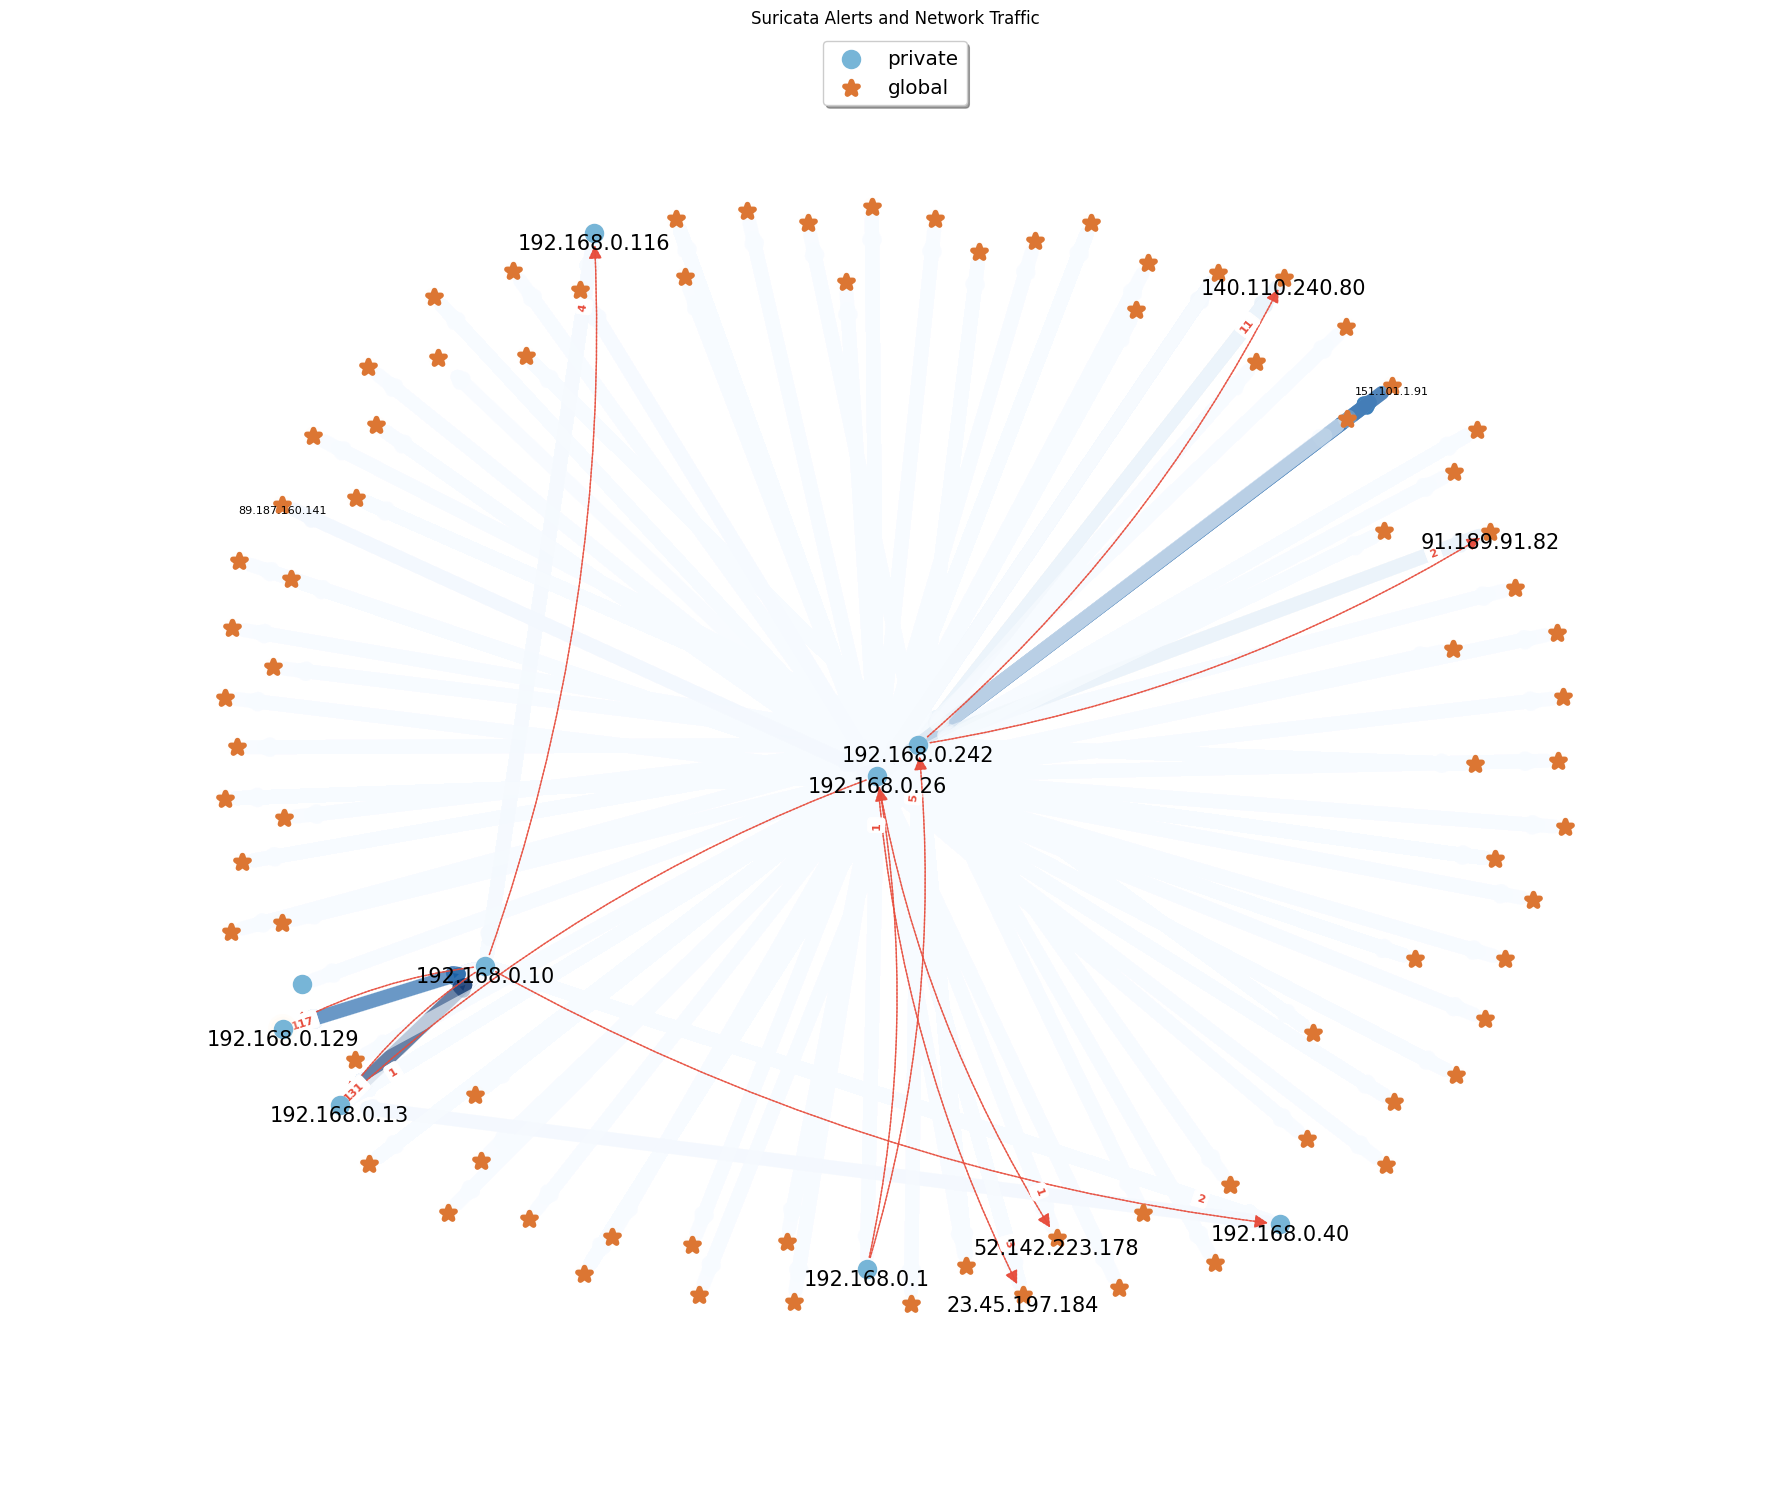

In [138]:
## Draw our graph
# Adjust the size of the figure to be plotted
plt.figure(figsize=fig_size)
# Set title
ax = plt.gca()
ax.set_title("Suricata Alerts and Network Traffic")
# Create the positioning for our graph using the Spring Layout.
# We're using "alertweight" for the layout weight, but you could also try "connweight", or even "severity" here
# k controls the distance between the nodes and varies between 0 and 1
# iterations is the number of times simulated annealing is run
# default k=0.1 and iterations=50
pos = nx.spring_layout(G, scale=1.2, k=0.9, iterations=50, weight='alertweight')

# Draw Zeek connection edges (severity 0), color edges on a blue scale by the connectin weight (based on the count of unique
# connections) for incoming and outgoing connections
nx.draw_networkx_edges(G, 
                       pos, 
                       width=10, 
                       style='solid',
                       edgelist=in_sev0,
                       edge_color=edge_weights_conn_in,
                       edge_cmap=plt.cm.Blues,
                       edge_vmin=0.1,
                       edge_vmax=10.1, 
                       alpha=0.6, 
                       arrows=True, 
                       min_source_margin=0.2,
                       min_target_margin=0.2)
nx.draw_networkx_edges(G, 
                       pos, 
                       width=10, 
                       style='solid',
                       edgelist=out_sev0,
                       edge_color=edge_weights_conn_out,
                       edge_cmap=plt.cm.Blues,
                       edge_vmin=0.1,
                       edge_vmax=10.1, 
                       alpha=0.6, 
                       arrows=True, 
                       min_source_margin=0.2,
                       min_target_margin=0.2)
# Draw all nodes based on our node_weights (based on alertweight). This will color nodes on a cool/warm scale,
# and also draw the node size based on the weight. We draw the nodes transparently, so that we can draw the node type on top
nx.draw_networkx_nodes(G, 
                       pos, 
                       nodelist=node_weights.keys(),
                       node_color=list(node_weights.values()),
                       cmap=plt.cm.OrRd,
                       vmin=0.1,
                       vmax=10.1,
                       node_shape='o',
                       linewidths=4,
                       alpha=0.2,
                       node_size=[v * 900 for v in node_weights.values()])


# Draw the type of node on top of each node, for global, private and reserved IP's
nx.draw_networkx_nodes(G, 
                       pos, 
                       nodelist=private_ips,
                       node_color='#77B5D7', 
                       node_shape='o',
                       linewidths=4,
                       alpha=1,
                       label='private',
                       node_size=100)
nx.draw_networkx_nodes(G, 
                       pos, 
                       nodelist=global_ips, 
                       node_color='#DC7633', 
                       node_shape='*',  
                       linewidths=4,
                       alpha=1,
                       label='global',
                       node_size=100)

nx.draw_networkx_nodes(G, 
                       pos, 
                       nodelist=reserved_ips, 
                       node_color='#C0392B', 
                       node_shape='P',  
                       linewidths=4,
                       alpha=1,
                       label='reserved',
                       node_size=100)

# Draw the corresponding labels for each node
# For Severity 1
nx.draw_networkx_labels(G, 
                        pos,
                        font_color='black',
                        verticalalignment='top',
                        labels=node_labels_sev1,
                        font_size=10)
# For Severity 2
nx.draw_networkx_labels(G, 
                        pos,
                        font_color='black',
                        verticalalignment='top',
                        labels=node_labels_sev2,
                        font_size=12)
# For Severity 3
nx.draw_networkx_labels(G, 
                        pos,
                        font_color='black',
                        verticalalignment='top',
                        labels=node_labels_sev3,
                        font_size=15)
# For connections with a connection weight of over 0.5
nx.draw_networkx_labels(G, 
                        pos,
                        font_color='black',
                        verticalalignment='top',
                        labels=node_labels_sev0,
                        font_size=8)

# Draw our edges and edge labels for each severity
# Red = 3
# Yellow = 2
# Green =1
# For the edge labels we show the count of Suricata alerts
nx.draw_networkx_edges(G, 
                       pos, 
                       edgelist=in_sev1, 
                       width=2, 
                       style='solid', 
                       connectionstyle='arc3,rad=0.05',
                       edge_color='#52BE80',
                       alpha=1, 
                       arrows=True,
                       arrowsize=20,
                       label='sev1',
                       min_source_margin=3.0,
                       min_target_margin=3.0)

nx.draw_networkx_edge_labels(G,
                             pos,
                             edge_labels=edge_labels_sev1_in,
                             label_pos=0.9,
                             font_color='#229954',
                             font_size=8)
nx.draw_networkx_edges(G, 
                       pos, 
                       edgelist=out_sev1, 
                       width=2, 
                       style='dashed', 
                       connectionstyle='arc3,rad=0.05',
                       edge_color='#52BE80',
                       alpha=1, 
                       arrows=True,
                       arrowsize=20,
                       min_source_margin=3.0,
                       min_target_margin=3.0)

nx.draw_networkx_edge_labels(G, 
                             pos, 
                             edge_labels=edge_labels_sev1_out, 
                             label_pos=0.9, 
                             font_color='#229954', 
                             font_size=8)

nx.draw_networkx_edges(G, 
                       pos, 
                       edgelist=in_sev2, 
                       width=1.5, 
                       style='solid', 
                       connectionstyle='arc3,rad=0.05',
                       edge_color='#F5B041',
                       alpha=1, 
                       arrows=True,
                       arrowsize=20,
                       label='sev2',
                       min_source_margin=3.0,
                       min_target_margin=3.0)

nx.draw_networkx_edge_labels(G, 
                             pos, 
                             edge_labels=edge_labels_sev2_in, 
                             label_pos=0.3, 
                             font_color='#F39C12', 
                             font_size=8)
nx.draw_networkx_edges(G, 
                       pos, 
                       edgelist=out_sev2, 
                       width=1.5, 
                       style='dashed', 
                       connectionstyle='arc3,rad=0.05',
                       edge_color='#F5B041',
                       alpha=1, 
                       arrows=True,
                       arrowsize=20,
                       min_source_margin=3.0,
                       min_target_margin=3.0)

nx.draw_networkx_edge_labels(G, 
                             pos, 
                             edge_labels=edge_labels_sev2_out, 
                             label_pos=0.3, 
                             font_color='#F39C12', 
                             font_size=8)

nx.draw_networkx_edges(G, 
                       pos,
                       edgelist=in_sev3, 
                       width=1, 
                       style='solid',
                       connectionstyle='arc3,rad=0.1',
                       edge_color='#E74C3C',
                       alpha=0.8, 
                       arrows=True,
                       arrowsize=20,
                       label='sev3',
                       min_source_margin=5.0,
                       min_target_margin=5.0)

nx.draw_networkx_edge_labels(G, 
                             pos, 
                             edge_labels=edge_labels_sev3_in, 
                             label_pos=0.1, 
                             font_color='#E74C3C', 
                             font_weight="bold", 
                             font_size=8)

nx.draw_networkx_edges(G, 
                       pos,
                       edgelist=out_sev3, 
                       width=1, 
                       style='dotted',
                       connectionstyle='arc3,rad=0.1',
                       edge_color='#E74C3C',
                       alpha=0.8, 
                       arrows=True,
                       arrowsize=20,
                       min_source_margin=5.0,
                       min_target_margin=5.0)

nx.draw_networkx_edge_labels(G, 
                             pos, 
                             edge_labels=edge_labels_sev3_out, 
                             label_pos=0.1, 
                             font_color='#E74C3C',
                             font_weight="bold", 
                             font_size=8)

# Draw without box lines
plt.box(on=None)
# Draw legend
plt.legend(loc='upper center', shadow=True, fontsize='x-large')
# Set margins
plt.gca().margins(0.1, 0.1)
# Set tight layout
plt.tight_layout()
plt.show()

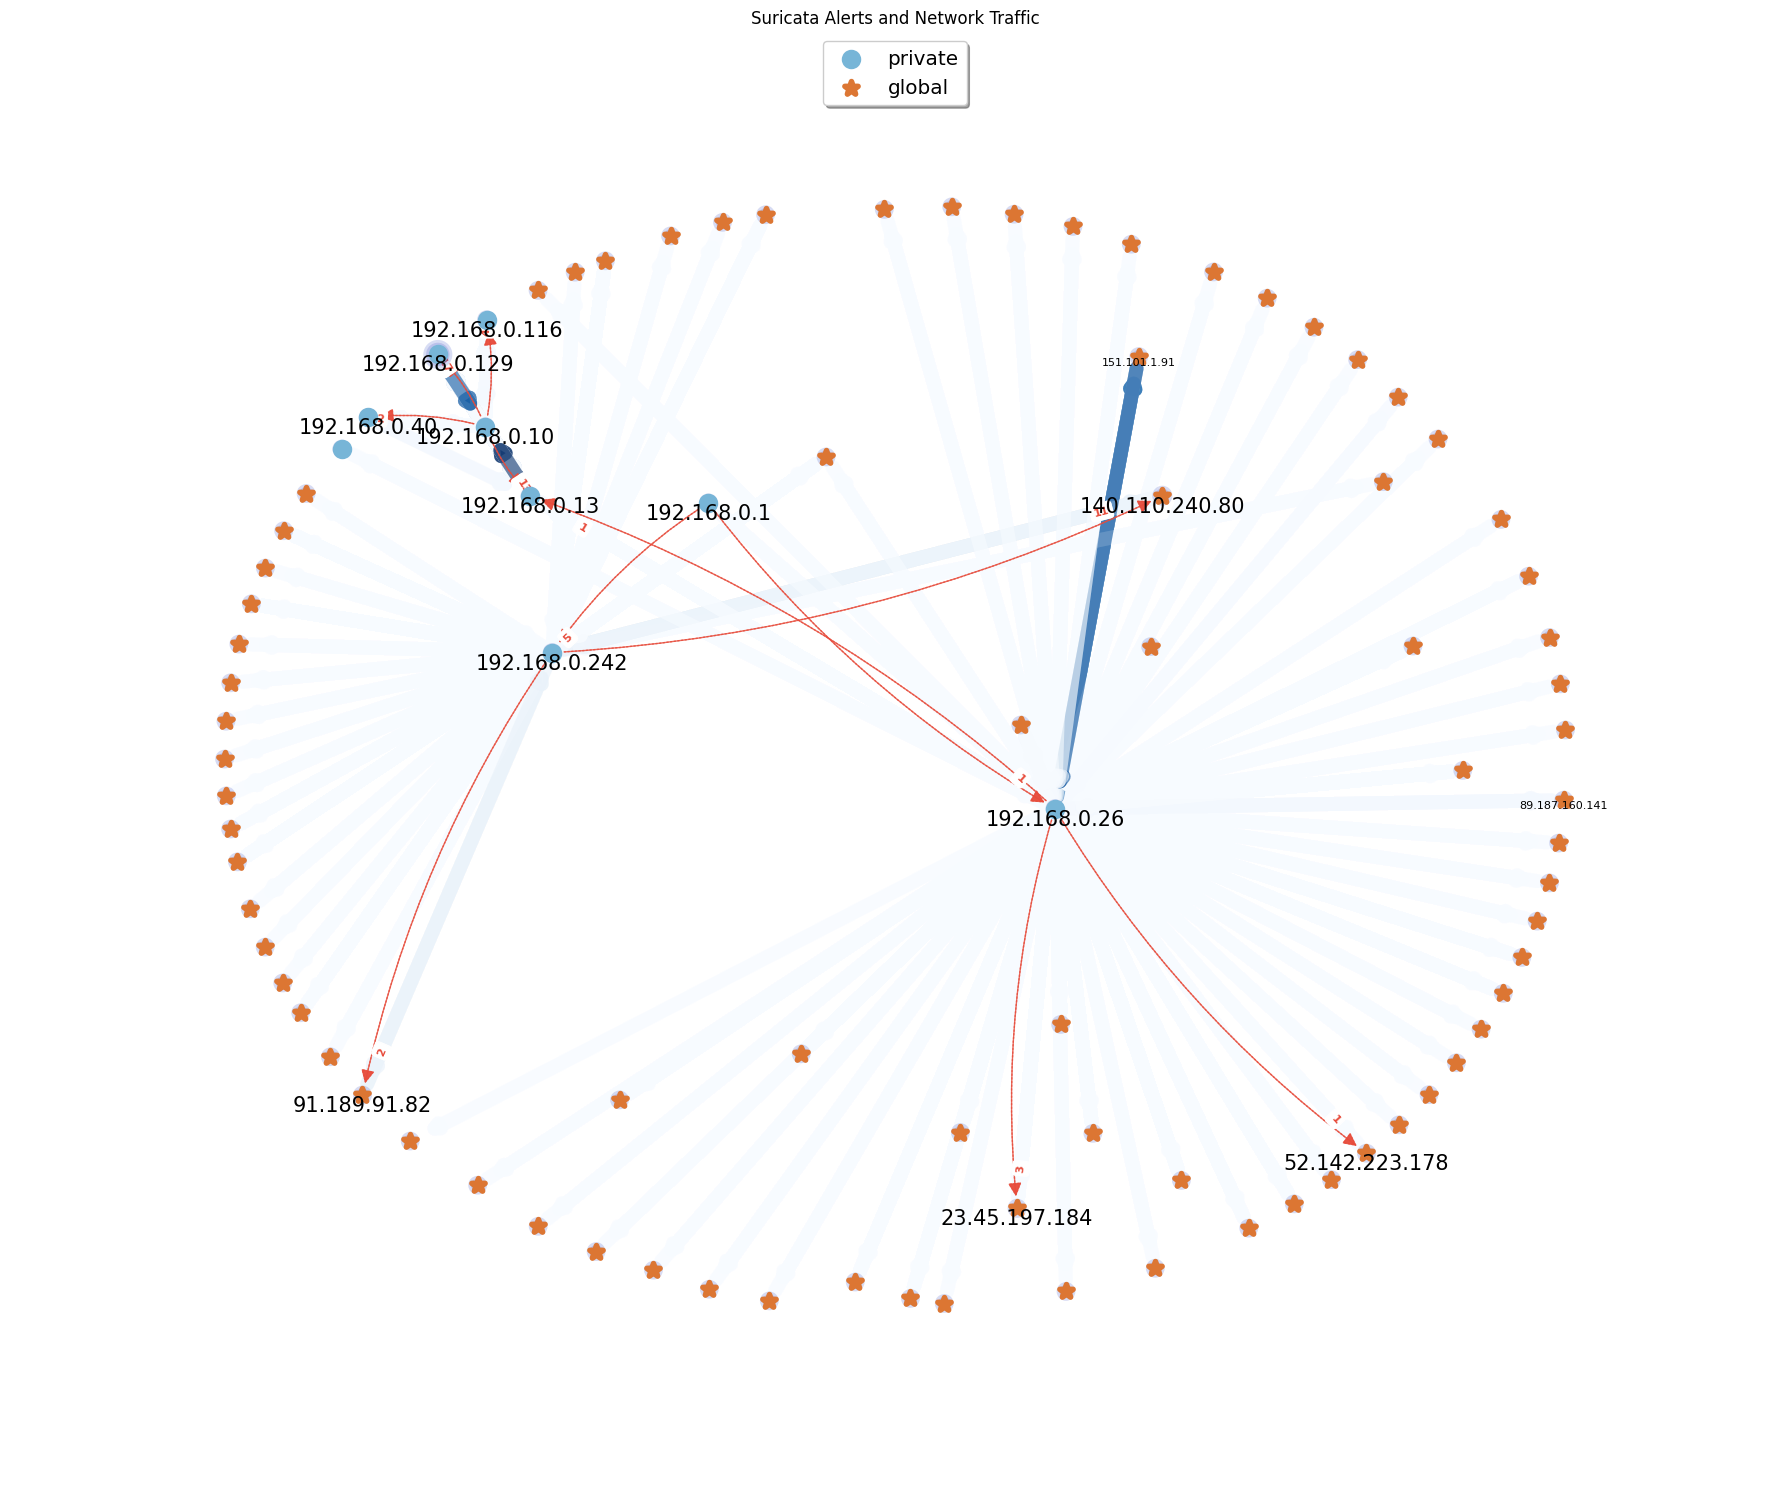

In [139]:
### graph 2 ###
## Draw our graph
# Adjust the size of the figure to be plotted
plt.figure(figsize=fig_size)
# Set title
ax = plt.gca()
ax.set_title("Suricata Alerts and Network Traffic")

# First we create a Circle layout for our graph
pos = nx.circular_layout(G)
# Then we generate a Spring layout graph using the circle layout for positioning 
# Once again, we're using "alertweight" for the layout weight, but you could also try "connweight", or even "severity" here
# k controls the distance between the nodes and varies between 0 and 1
# iterations is the number of times simulated annealing is run
# default k=0.1 and iterations=50
pos = nx.spring_layout(G, pos=pos, k=0.9, scale=1.2, iterations=50, weight='alertweight')

# draw edges
# Draw Zeek connection edges (severity 0), color edges on a blue scale by the connectin weight (based on the count of unique
# connections) for incoming and outgoing connections
nx.draw_networkx_edges(G, 
                       pos, 
                       width=10, 
                       style='solid',
                       edgelist=in_sev0,
                       edge_color=edge_weights_conn_in,
                       edge_cmap=plt.cm.Blues,
                       edge_vmin=0.1,
                       edge_vmax=10.1, 
                       alpha=0.6, 
                       arrows=True, 
                       min_source_margin=0.2,
                       min_target_margin=0.2)
nx.draw_networkx_edges(G, 
                       pos, 
                       width=10, 
                       style='solid',
                       edgelist=out_sev0,
                       edge_color=edge_weights_conn_out,
                       edge_cmap=plt.cm.Blues,
                       edge_vmin=0.1,
                       edge_vmax=10.1, 
                       alpha=0.6, 
                       arrows=True, 
                       min_source_margin=0.2,
                       min_target_margin=0.2)
# Draw all nodes based on our node_weights (based on alertweight). This will color nodes on a cool/warm scale,
# and also draw the node size based on the weight. We draw the nodes transparently, so that we can draw the node type on top
nx.draw_networkx_nodes(G, 
                       pos, 
                       nodelist=node_weights.keys(),
                       node_color=list(node_weights.values()),
                       cmap=plt.cm.coolwarm,
                       vmin=0.1,
                       vmax=10.1,
                       node_shape='o',
                       linewidths=4,
                       alpha=0.2,
                       node_size=[v * 900 for v in node_weights.values()])


# Draw the type of node on top of each node, for global, private and reserved IP's
nx.draw_networkx_nodes(G, 
                       pos, 
                       nodelist=private_ips,
                       node_color='#77B5D7', 
                       node_shape='o',
                       linewidths=4,
                       alpha=1,
                       label='private',
                       node_size=100)
nx.draw_networkx_nodes(G, 
                       pos, 
                       nodelist=global_ips, 
                       node_color='#DC7633', 
                       node_shape='*',  
                       linewidths=4,
                       alpha=1,
                       label='global',
                       node_size=100)

nx.draw_networkx_nodes(G, 
                       pos, 
                       nodelist=reserved_ips, 
                       node_color='#C0392B', 
                       node_shape='P',  
                       linewidths=4,
                       alpha=1,
                       label='reserved',
                       node_size=100)

# Draw the corresponding labels for each node
# For Severity 1
nx.draw_networkx_labels(G, 
                        pos,
                        font_color='black',
                        verticalalignment='top',
                        labels=node_labels_sev1,
                        font_size=10)
# For Severity 2
nx.draw_networkx_labels(G, 
                        pos,
                        font_color='black',
                        verticalalignment='top',
                        labels=node_labels_sev2,
                        font_size=12)
# For Severity 3
nx.draw_networkx_labels(G, 
                        pos,
                        font_color='black',
                        verticalalignment='top',
                        labels=node_labels_sev3,
                        font_size=15)
# For connections with a connection weight of over 0.5
nx.draw_networkx_labels(G, 
                        pos,
                        font_color='black',
                        verticalalignment='top',
                        labels=node_labels_sev0,
                        font_size=8)

# Draw our edges and edge labels for each severity
# Red = 3
# Yellow = 2
# Green =1
# For the edge labels we show the count of Suricata alerts
nx.draw_networkx_edges(G, 
                       pos, 
                       edgelist=in_sev1, 
                       width=2, 
                       style='solid', 
                       connectionstyle='arc3,rad=0.05',
                       edge_color='#52BE80',
                       alpha=1, 
                       arrows=True,
                       arrowsize=20,
                       label='sev1',
                       min_source_margin=1.0,
                       min_target_margin=1.0)

nx.draw_networkx_edge_labels(G,
                             pos,
                             edge_labels=edge_labels_sev1_in,
                             label_pos=0.9,
                             font_color='#229954',
                             font_size=8)
nx.draw_networkx_edges(G, 
                       pos, 
                       edgelist=out_sev1, 
                       width=2, 
                       style='dashed', 
                       connectionstyle='arc3,rad=0.05',
                       edge_color='#52BE80',
                       alpha=1, 
                       arrows=True,
                       arrowsize=20,
                       min_source_margin=1.0,
                       min_target_margin=1.0)

nx.draw_networkx_edge_labels(G, 
                             pos, 
                             edge_labels=edge_labels_sev1_out, 
                             label_pos=0.9, 
                             font_color='#229954', 
                             font_size=8)

nx.draw_networkx_edges(G, 
                       pos, 
                       edgelist=in_sev2, 
                       width=1.5, 
                       style='solid', 
                       connectionstyle='arc3,rad=0.05',
                       edge_color='#F5B041',
                       alpha=1, 
                       arrows=True,
                       arrowsize=20,
                       label='sev2',
                       min_source_margin=1.0,
                       min_target_margin=1.0)

nx.draw_networkx_edge_labels(G, 
                             pos, 
                             edge_labels=edge_labels_sev2_in, 
                             label_pos=0.3, 
                             font_color='#F39C12', 
                             font_size=8)
nx.draw_networkx_edges(G, 
                       pos, 
                       edgelist=out_sev2, 
                       width=1.5, 
                       style='dashed', 
                       connectionstyle='arc3,rad=0.05',
                       edge_color='#F5B041',
                       alpha=1, 
                       arrows=True,
                       arrowsize=20,
                       min_source_margin=1.0,
                       min_target_margin=1.0)

nx.draw_networkx_edge_labels(G, 
                             pos, 
                             edge_labels=edge_labels_sev2_out, 
                             label_pos=0.3, 
                             font_color='#F39C12', 
                             font_size=8)

nx.draw_networkx_edges(G, 
                       pos,
                       edgelist=in_sev3, 
                       width=1, 
                       style='solid',
                       connectionstyle='arc3,rad=0.1',
                       edge_color='#E74C3C',
                       alpha=0.8, 
                       arrows=True,
                       arrowsize=20,
                       label='sev3',
                       min_source_margin=5.0,
                       min_target_margin=5.0)

nx.draw_networkx_edge_labels(G, 
                             pos, 
                             edge_labels=edge_labels_sev3_in, 
                             label_pos=0.1, 
                             font_color='#E74C3C', 
                             font_weight="bold", 
                             font_size=8)

nx.draw_networkx_edges(G, 
                       pos,
                       edgelist=out_sev3, 
                       width=1, 
                       style='dotted',
                       connectionstyle='arc3,rad=0.1',
                       edge_color='#E74C3C',
                       alpha=0.8, 
                       arrows=True,
                       arrowsize=20,
                       min_source_margin=5.0,
                       min_target_margin=5.0)

nx.draw_networkx_edge_labels(G, 
                             pos, 
                             edge_labels=edge_labels_sev3_out, 
                             label_pos=0.1, 
                             font_color='#E74C3C',
                             font_weight="bold", 
                             font_size=8)

# Draw without box lines
plt.box(on=None)
# Draw legend
plt.legend(loc='upper center', shadow=True, fontsize='x-large')
# Set margins
plt.gca().margins(0.1, 0.1)
# Set tight layout
plt.tight_layout()
plt.show()

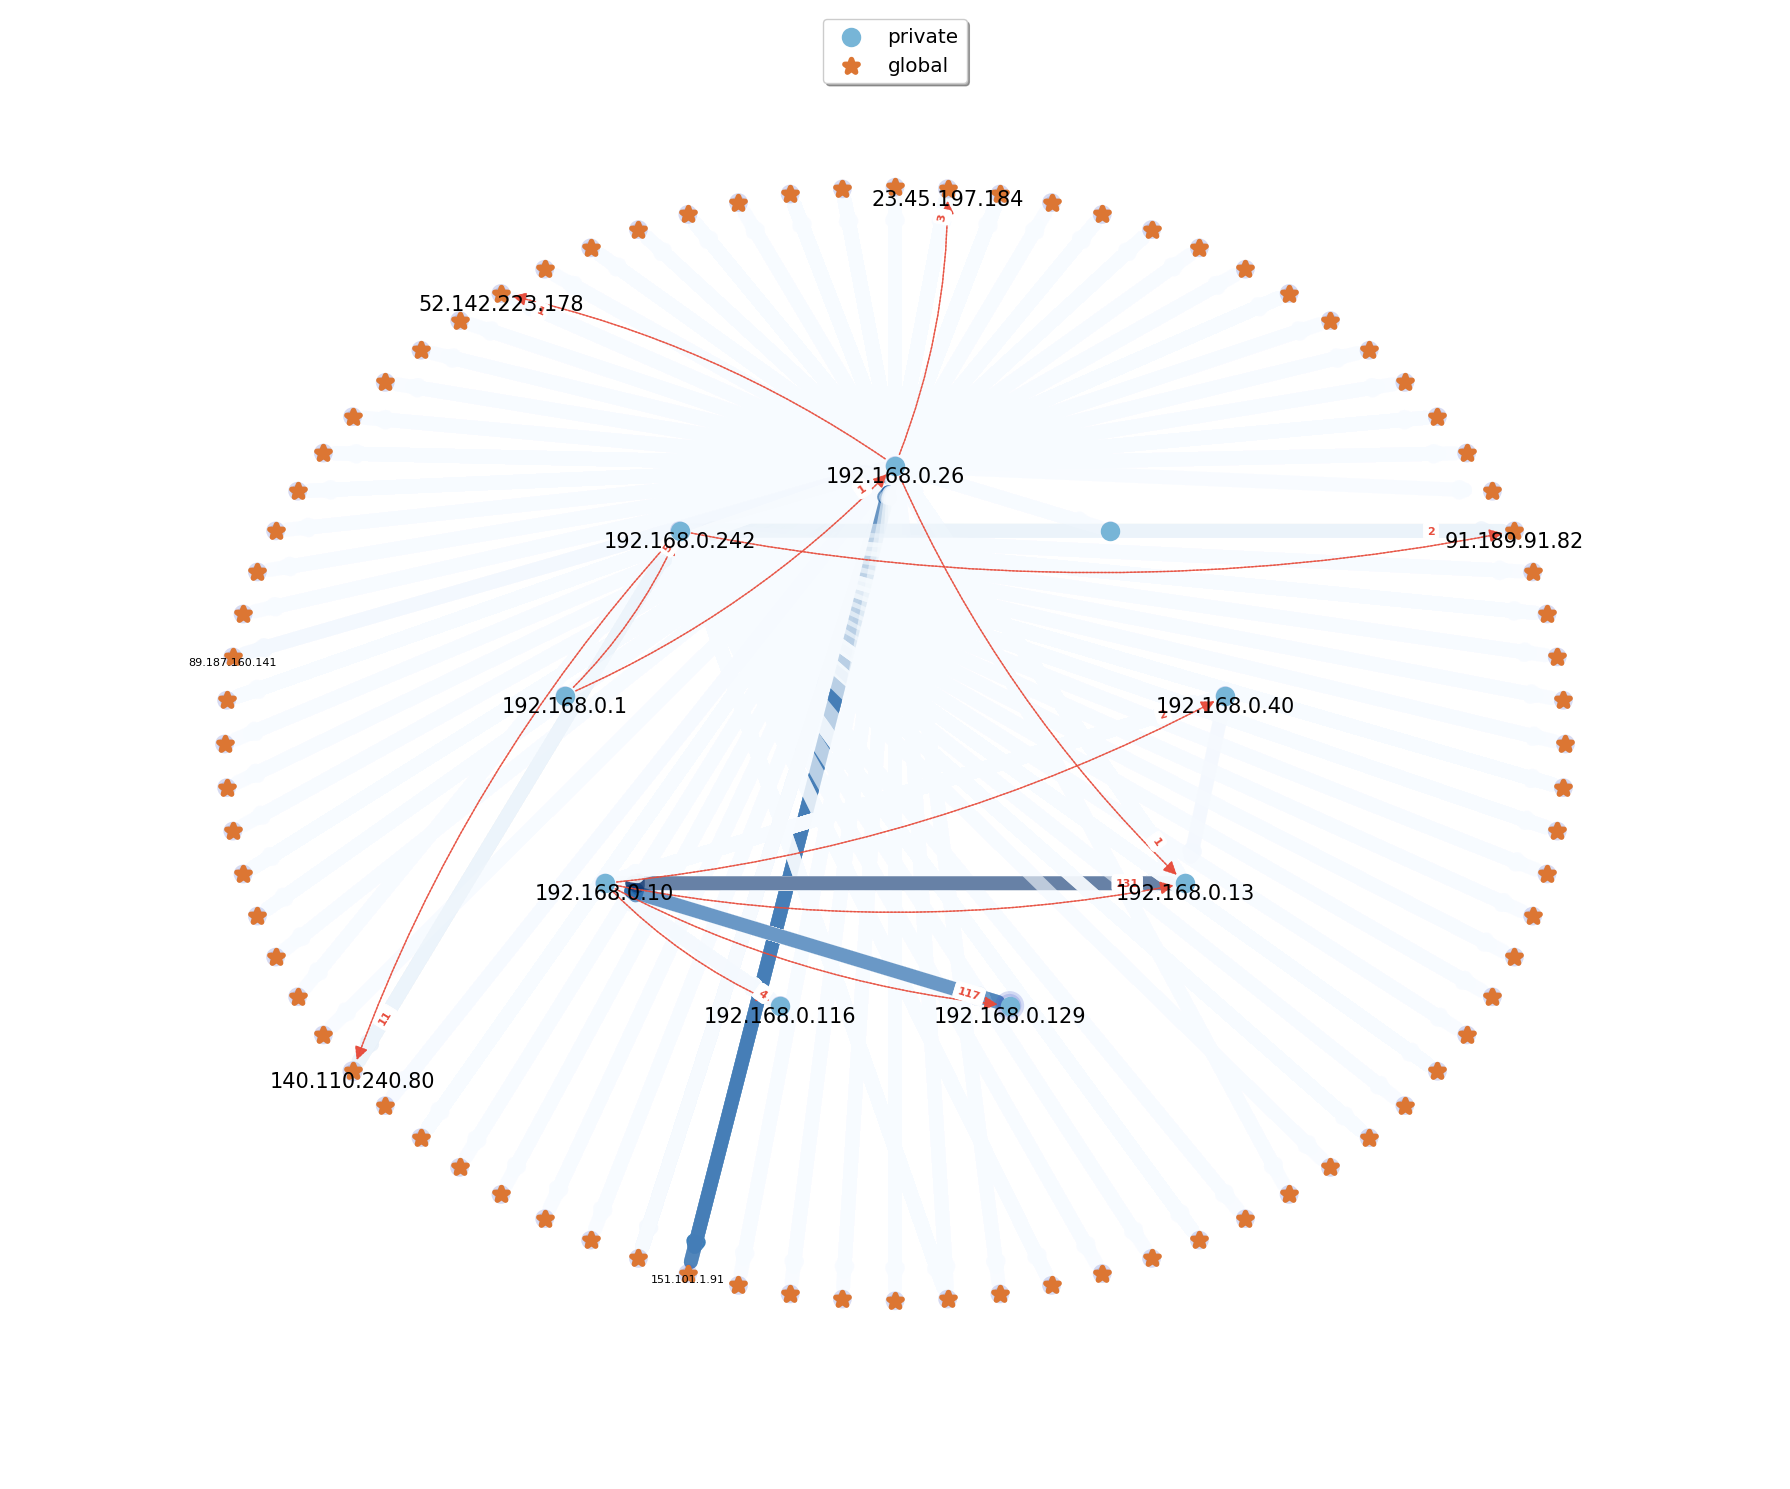

In [140]:
shells = [private_ips, global_ips]
plt.figure(figsize=fig_size)
pos = nx.shell_layout(G, nlist=shells, scale=2)
# draw edges
# Draw Zeek connection edges (severity 0), color edges on a blue scale by the connectin weight (based on the count of unique
# connections) for incoming and outgoing connections
nx.draw_networkx_edges(G, 
                       pos, 
                       width=10, 
                       style='solid',
                       edgelist=in_sev0,
                       edge_color=edge_weights_conn_in,
                       edge_cmap=plt.cm.Blues,
                       edge_vmin=0.1,
                       edge_vmax=10.1, 
                       alpha=0.6, 
                       arrows=True, 
                       min_source_margin=0.2,
                       min_target_margin=0.2)
nx.draw_networkx_edges(G, 
                       pos, 
                       width=10, 
                       style='solid',
                       edgelist=out_sev0,
                       edge_color=edge_weights_conn_out,
                       edge_cmap=plt.cm.Blues,
                       edge_vmin=0.1,
                       edge_vmax=10.1, 
                       alpha=0.6, 
                       arrows=True, 
                       min_source_margin=0.2,
                       min_target_margin=0.2)
# Draw all nodes based on our node_weights (based on alertweight). This will color nodes on a cool/warm scale,
# and also draw the node size based on the weight. We draw the nodes transparently, so that we can draw the node type on top
nx.draw_networkx_nodes(G, 
                       pos, 
                       nodelist=node_weights.keys(),
                       node_color=list(node_weights.values()),
                       cmap=plt.cm.coolwarm,
                       vmin=0.1,
                       vmax=10.1,
                       node_shape='o',
                       linewidths=4,
                       alpha=0.2,
                       node_size=[v * 900 for v in node_weights.values()])


# Draw the type of node on top of each node, for global, private and reserved IP's
nx.draw_networkx_nodes(G, 
                       pos, 
                       nodelist=private_ips,
                       node_color='#77B5D7', 
                       node_shape='o',
                       linewidths=4,
                       alpha=1,
                       label='private',
                       node_size=100)
nx.draw_networkx_nodes(G, 
                       pos, 
                       nodelist=global_ips, 
                       node_color='#DC7633', 
                       node_shape='*',  
                       linewidths=4,
                       alpha=1,
                       label='global',
                       node_size=100)

nx.draw_networkx_nodes(G, 
                       pos, 
                       nodelist=reserved_ips, 
                       node_color='#C0392B', 
                       node_shape='P',  
                       linewidths=4,
                       alpha=1,
                       label='reserved',
                       node_size=100)

# Draw the corresponding labels for each node
# For Severity 1
nx.draw_networkx_labels(G, 
                        pos,
                        font_color='black',
                        verticalalignment='top',
                        labels=node_labels_sev1,
                        font_size=10)
# For Severity 2
nx.draw_networkx_labels(G, 
                        pos,
                        font_color='black',
                        verticalalignment='top',
                        labels=node_labels_sev2,
                        font_size=12)
# For Severity 3
nx.draw_networkx_labels(G, 
                        pos,
                        font_color='black',
                        verticalalignment='top',
                        labels=node_labels_sev3,
                        font_size=15)
# For connections with a connection weight of over 0.5
nx.draw_networkx_labels(G, 
                        pos,
                        font_color='black',
                        verticalalignment='top',
                        labels=node_labels_sev0,
                        font_size=8)

# Draw our edges and edge labels for each severity
# Red = 3
# Yellow = 2
# Green =1
# For the edge labels we show the count of Suricata alerts
nx.draw_networkx_edges(G, 
                       pos, 
                       edgelist=in_sev1, 
                       width=2, 
                       style='solid', 
                       connectionstyle='arc3,rad=0.05',
                       edge_color='#52BE80',
                       alpha=1, 
                       arrows=True,
                       arrowsize=20,
                       label='sev1',
                       min_source_margin=1.0,
                       min_target_margin=1.0)

nx.draw_networkx_edge_labels(G,
                             pos,
                             edge_labels=edge_labels_sev1_in,
                             label_pos=0.9,
                             font_color='#229954',
                             font_size=8)
nx.draw_networkx_edges(G, 
                       pos, 
                       edgelist=out_sev1, 
                       width=2, 
                       style='dashed', 
                       connectionstyle='arc3,rad=0.05',
                       edge_color='#52BE80',
                       alpha=1, 
                       arrows=True,
                       arrowsize=20,
                       min_source_margin=1.0,
                       min_target_margin=1.0)

nx.draw_networkx_edge_labels(G, 
                             pos, 
                             edge_labels=edge_labels_sev1_out, 
                             label_pos=0.9, 
                             font_color='#229954', 
                             font_size=8)

nx.draw_networkx_edges(G, 
                       pos, 
                       edgelist=in_sev2, 
                       width=1.5, 
                       style='solid', 
                       connectionstyle='arc3,rad=0.05',
                       edge_color='#F5B041',
                       alpha=1, 
                       arrows=True,
                       arrowsize=20,
                       label='sev2',
                       min_source_margin=1.0,
                       min_target_margin=1.0)

nx.draw_networkx_edge_labels(G, 
                             pos, 
                             edge_labels=edge_labels_sev2_in, 
                             label_pos=0.3, 
                             font_color='#F39C12', 
                             font_size=8)
nx.draw_networkx_edges(G, 
                       pos, 
                       edgelist=out_sev2, 
                       width=1.5, 
                       style='dashed', 
                       connectionstyle='arc3,rad=0.05',
                       edge_color='#F5B041',
                       alpha=1, 
                       arrows=True,
                       arrowsize=20,
                       min_source_margin=1.0,
                       min_target_margin=1.0)

nx.draw_networkx_edge_labels(G, 
                             pos, 
                             edge_labels=edge_labels_sev2_out, 
                             label_pos=0.3, 
                             font_color='#F39C12', 
                             font_size=8)

nx.draw_networkx_edges(G, 
                       pos,
                       edgelist=in_sev3, 
                       width=1, 
                       style='solid',
                       connectionstyle='arc3,rad=0.1',
                       edge_color='#E74C3C',
                       alpha=0.8, 
                       arrows=True,
                       arrowsize=20,
                       label='sev3',
                       min_source_margin=5.0,
                       min_target_margin=5.0)

nx.draw_networkx_edge_labels(G, 
                             pos, 
                             edge_labels=edge_labels_sev3_in, 
                             label_pos=0.1, 
                             font_color='#E74C3C', 
                             font_weight="bold", 
                             font_size=8)

nx.draw_networkx_edges(G, 
                       pos,
                       edgelist=out_sev3, 
                       width=1, 
                       style='dotted',
                       connectionstyle='arc3,rad=0.1',
                       edge_color='#E74C3C',
                       alpha=0.8, 
                       arrows=True,
                       arrowsize=20,
                       min_source_margin=5.0,
                       min_target_margin=5.0)

nx.draw_networkx_edge_labels(G, 
                             pos, 
                             edge_labels=edge_labels_sev3_out, 
                             label_pos=0.1, 
                             font_color='#E74C3C',
                             font_weight="bold", 
                             font_size=8)

# Draw without box lines
plt.box(on=None)
# Draw legend
plt.legend(loc='upper center', shadow=True, fontsize='x-large')
# Set margins
plt.gca().margins(0.1, 0.1)
# Set tight layout
plt.tight_layout()
plt.show()

In [141]:
import pandas as pd
import json

def extract_info_from_json(file_path):
    records = []

    # 逐行讀取 JSON 檔案
    with open(file_path, 'r') as file:
        for line in file:
            try:
                # 解析每行的 JSON 內容
                entry = json.loads(line)

                # 檢查 'alert' 鍵是否存在於 JSON 物件中
                if 'alert' in entry:
                    # 提取所需欄位
                    record = {
                        'source': entry['src_ip'],
                        'target': entry['dest_ip'],
                        'port': entry['dest_port'],
                        'severity': entry['alert']['severity'],
                        'signature_id': entry['alert']['signature_id']
                    }
                    records.append(record)
            except json.JSONDecodeError:
                # 處理可能的 JSON 解析錯誤
                continue

    # 創建 DataFrame
    df = pd.DataFrame(records)

    # 計算每個唯一組合的出現次數，並合併重複的行
    df = df.groupby(['source', 'target', 'port', 'signature_id']).agg({'severity': 'first', 'signature_id': 'size'}).rename(columns={'signature_id': 'alertcount'}).reset_index()

    # 保留所需欄位
    df = df[['source', 'target', 'port', 'alertcount', 'severity']]

    return df

# 使用範例
# file_path = 'your_json_file.json'  # 替換為 JSON 檔案路徑
# df = extract_info_from_json(file_path)
# print(df)
